In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

from models.simple_cnn import SimpleCNN
from models.cnn_v2 import CNNV2
from helpers.helpers import SequenceDataset
from helpers.plots import plot_losses, plot_predictions_vs_labels, plot_predictions_vs_labels_by_species, plot_boxplot_predictions_vs_labels
from helpers.early_stopping import EarlyStopping

from torch.utils.data import DataLoader

from ray import tune
from ray.tune.schedulers import ASHAScheduler

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

# Load the data
def load_dataframe(data_df=None):
    if data_df is not None:
        return data_df
    data_df = pd.read_csv('combined_data.csv')
    # get mean of each stress condition
    averages_df = data_df.copy()
    stress_conditions = set([name.split('_')[0] for name in data_df.columns if 'TPM' in name])
    for stress in stress_conditions:
        stress_columns = [name for name in data_df.columns if stress+'_' in name]
        averages_df[f'{stress}'] = np.mean([data_df[stress_columns[0]], data_df[stress_columns[1]], data_df[stress_columns[2]]], axis=0)

    # Drop the columns that are not needed
    averages_df = averages_df.drop(columns=[name for name in averages_df.columns if 'TPM' in name] + ['Chromosome','Region','Species', 'Unnamed: 0'])
    # drop rows with missing upstream200 sequences
    averages_df = averages_df.dropna(subset=['upstream200'])
    # drop rows with upstream200 sequences that contain anything but A, T, C, G
    averages_df = averages_df[averages_df['upstream200'].apply(lambda x: set(x).issubset({'A', 'T', 'C', 'G'}))]


    mlb = MultiLabelBinarizer()
    # map each species id to a one hot encoding
    averages_df['Species ID'] = averages_df['Species ID'].apply(lambda x: [x])
    averages_df['Species ID'] = mlb.fit_transform(averages_df['Species ID']).tolist()

    # map each base to one hot encoding
    base_encodings = {'A': [1,0,0,0], 'T': [0,1,0,0], 'C': [0,0,1,0], 'G': [0,0,0,1]}
    longest_sequence = max(averages_df['upstream200'].apply(lambda x: len(x)))
    averages_df['upstream200'] = averages_df['upstream200'].apply(lambda x: [base_encodings[base] for base in x] + [[0,0,0,0]]*(longest_sequence-len(x)))

    # explode dataset to have one row per stress condition
    averages_df['Stress'] = averages_df.apply(lambda row: [{stress:row[stress]} for stress in stress_conditions], axis=1)
    averages_df = averages_df.drop(columns=[name for name in averages_df.columns if name in stress_conditions])

    averages_df = averages_df.explode('Stress')
    averages_df['Stress_name'] = averages_df['Stress'].apply(lambda x: list(x.keys())[0])
    averages_df['Stress'] = averages_df['Stress'].apply(lambda x: list(x.values())[0])

    # one hot encode stress names
    averages_df['Stress_name'] = averages_df['Stress_name'].apply(lambda x: [x])
    averages_df['Stress_name'] = mlb.fit_transform(averages_df['Stress_name']).tolist()

    # drop rows with 0 stress
    averages_df = averages_df[averages_df['Stress'] > 0]

    # log values of stress conditions
    averages_df['Stress'] = averages_df['Stress'].apply(lambda x: np.log(x+1))

    data_df = averages_df
    return averages_df


In [3]:
def load_data(species_id = -1, size = -1 ,val_split = 0.2 , test_split = 0.1, data_df=None):
    data_df = load_dataframe(data_df)
    
    if species_id != -1:
        data_df = data_df[data_df['Species ID'].apply(lambda x: x[species_id] == 1)]
    if size != -1:
        size = int(size * 1.39)
        data_df = data_df.sample(size)

    # split the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(data_df[['Species ID', 'Stress_name', 'upstream200']], data_df['Stress'], test_size=test_split)

    # create a dataset
    train_dataset = SequenceDataset(X_train, y_train)
    test_dataset = SequenceDataset(X_test, y_test)

    return train_dataset, test_dataset


In [42]:
def train(config):
    if config['model_version'] == 1:
        net = CNNV2(**config)
    elif config['model_version'] == 0:
        net = SimpleCNN(**config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config['lr'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    early_stopping = EarlyStopping(patience=7, verbose=True)

    
    train_dataset, test_dataset = load_data(species_id=config['species_id'], size=config['test_size'], data_df=config['data_df'])
    print(f"Training on {len(train_dataset)} samples, testing on {len(test_dataset)} samples")

    train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2)
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)

    train_losses = []
    val_losses = []

    for epoch in range(config['epochs']):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = [i.to(device) for i in inputs], labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()

        train_losses.append(running_loss/len(train_loader))
        
        net.eval()
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = [i.to(device) for i in inputs], labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.cpu().detach().numpy()
            val_steps += 1

        val_losses.append(val_loss/val_steps)
        scheduler.step(val_loss)

        print(f"Epoch {epoch}, train loss: {running_loss/len(train_loader)} validation loss: {val_loss/len(val_loader)}")
        early_stopping(val_loss / val_steps, net)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    return net, train_losses, val_losses, test_dataset


def predict(config, net, test_dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    all_predictions = []
    all_labels = []
    all_species_ids = []
    all_stress_ids = []
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            inputs = [i.to(device) for i in inputs]
            labels = labels.to(device)

            outputs = net(inputs)
            species_ids = np.argmax(inputs[0].cpu().numpy(), axis=1)
            stress_ids = np.argmax(inputs[1].cpu().numpy(), axis=1)

            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_species_ids.append(species_ids)
            all_stress_ids.append(stress_ids)


    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_species_ids = np.concatenate(all_species_ids, axis=0)
    all_stress_ids = np.concatenate(all_stress_ids, axis=0)

    return all_predictions, all_labels, all_species_ids, all_stress_ids
    

def evaluate(predictions, labels):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(labels, predictions)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(labels, predictions)

    # Calculate R-squared (R²)
    r2 = r2_score(labels, predictions)
    
    return mse, mae, r2


In [12]:
data_df = load_dataframe()

In [8]:
data_df

,Species ID,upstream200,Stress,Stress_name
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",7.350767,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",8.137598,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",7.686150,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",8.157670,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 0, 1, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,...",9.060965,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
...,...,...,...,...
96410,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1,...",6.861541,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
96410,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1,...",5.805207,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
96410,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1,...",5.170262,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
96410,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1,...",5.783542,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [43]:
config = {
    'lr': 0.001,
    'batch_size': 1024,
    'epochs': 100,
    'species_id': -1,
    'test_size': 20000,
    'hidden_size': 60,
    'model_version': 1,
    'data_df': data_df
}

net, train_losses, val_losses, test_dataset = train(config)



Training on 25019 samples, testing on 2780 samples
Epoch 0, train loss: 8.660233449935912 validation loss: 17.304394149780272
Validation loss decreased (inf --> 17.304394).  Saving model ...
Epoch 1, train loss: 4.999394726753235 validation loss: 14.144274711608887
Validation loss decreased (17.304394 --> 14.144275).  Saving model ...
Epoch 2, train loss: 4.30699098110199 validation loss: 9.836984443664551
Validation loss decreased (14.144275 --> 9.836984).  Saving model ...
Epoch 3, train loss: 3.860503387451172 validation loss: 4.912050437927246
Validation loss decreased (9.836984 --> 4.912050).  Saving model ...
Epoch 4, train loss: 3.5963506937026977 validation loss: 3.551300811767578
Validation loss decreased (4.912050 --> 3.551301).  Saving model ...
Epoch 5, train loss: 3.416025972366333 validation loss: 3.5708096027374268
EarlyStopping counter: 1 out of 7
Epoch 6, train loss: 3.3048219799995424 validation loss: 3.4432833671569822
Validation loss decreased (3.551301 --> 3.443283

In [44]:
# Test configuration
config = {
    'batch_size': 1024,
}

# Run predictions
predictions, labels, species_ids, all_stress_ids = predict(config, net, test_dataset)

# Evaluate regression metrics
mse, mae, r2 = evaluate(predictions, labels)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


Mean Squared Error: 2.6509790420532227
Mean Absolute Error: 1.2866125106811523
R-squared: 0.2151509348421755


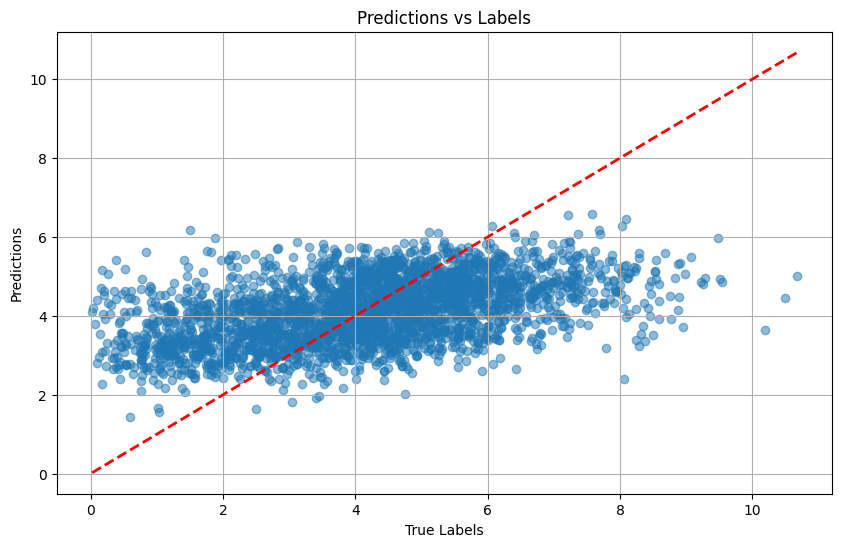

In [45]:
plot_predictions_vs_labels(predictions, labels)


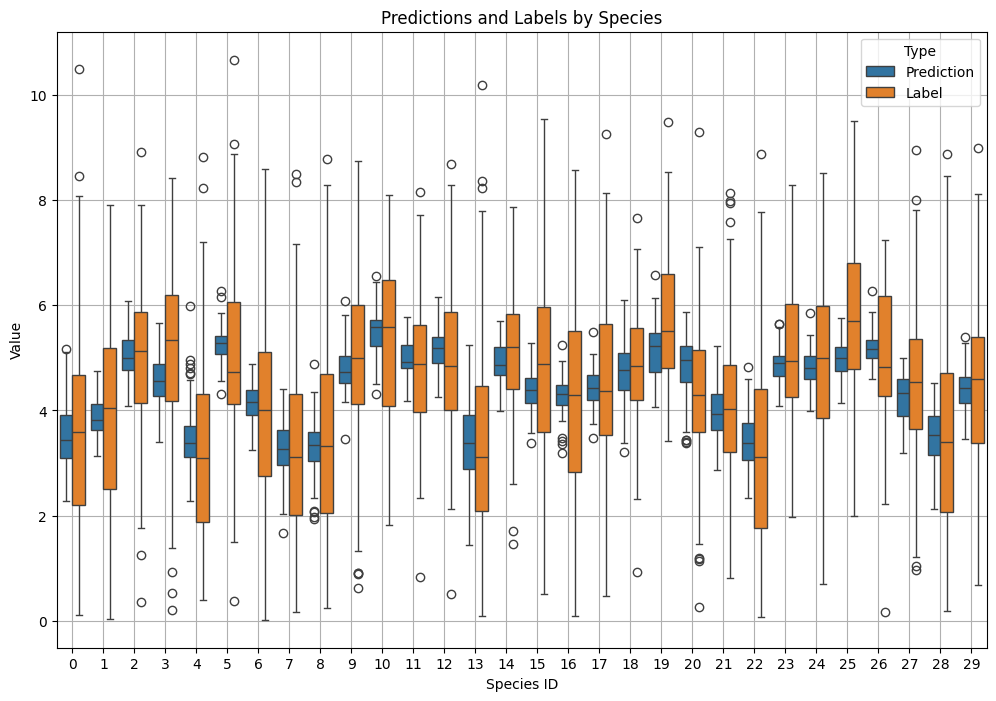

In [46]:
# Plot the boxplot
plot_boxplot_predictions_vs_labels(predictions, labels, species_ids, by_label='Species')

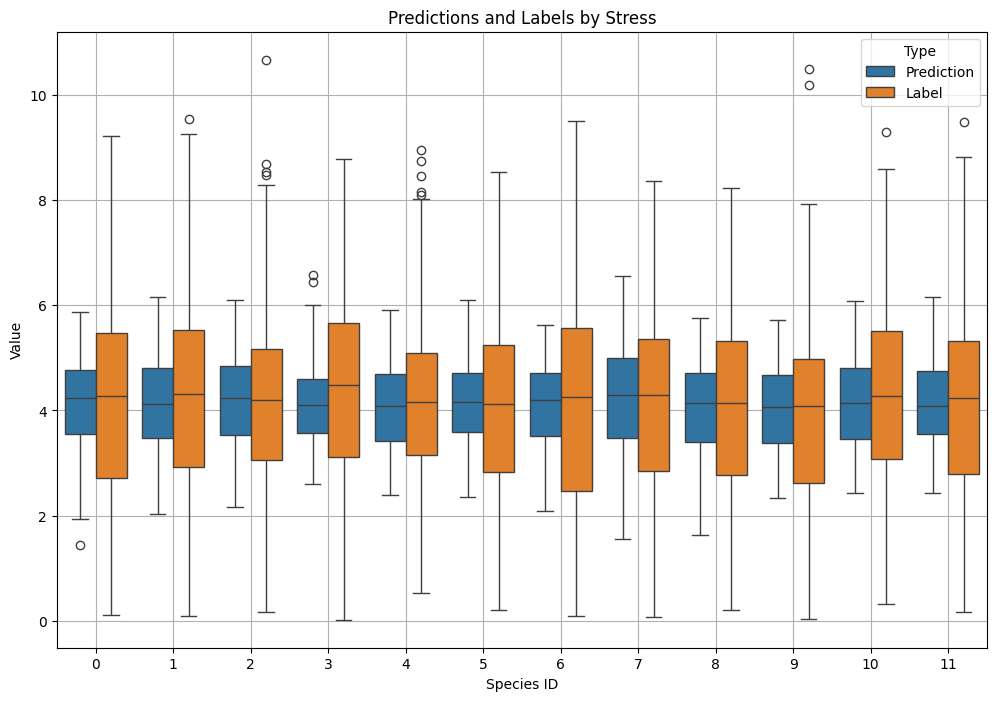

In [47]:
# Plot the boxplot
plot_boxplot_predictions_vs_labels(predictions, labels, all_stress_ids, by_label='Stress')

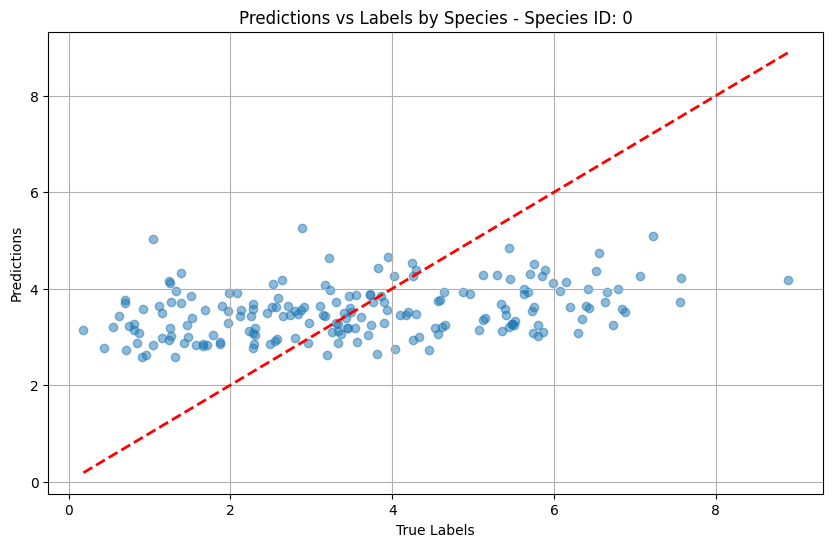

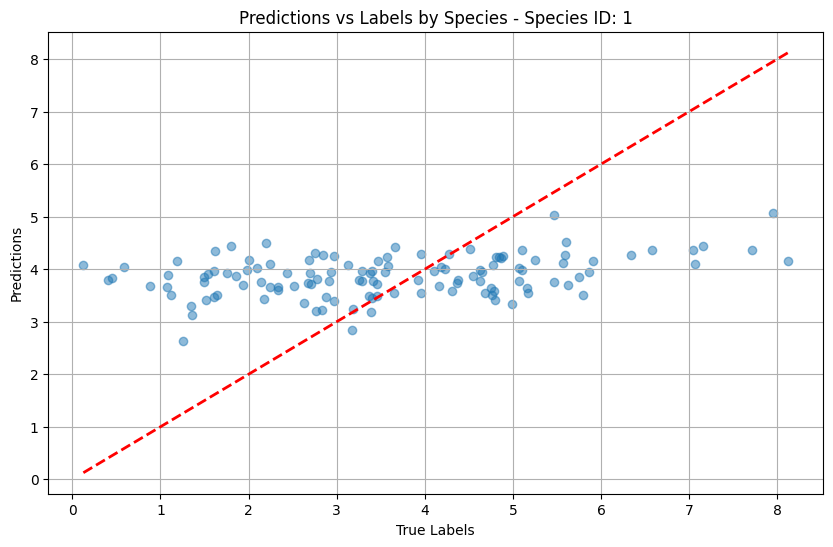

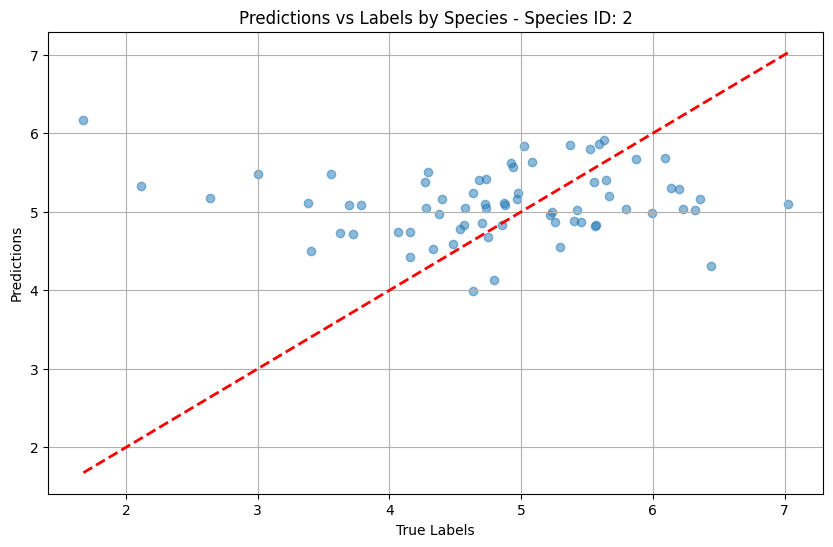

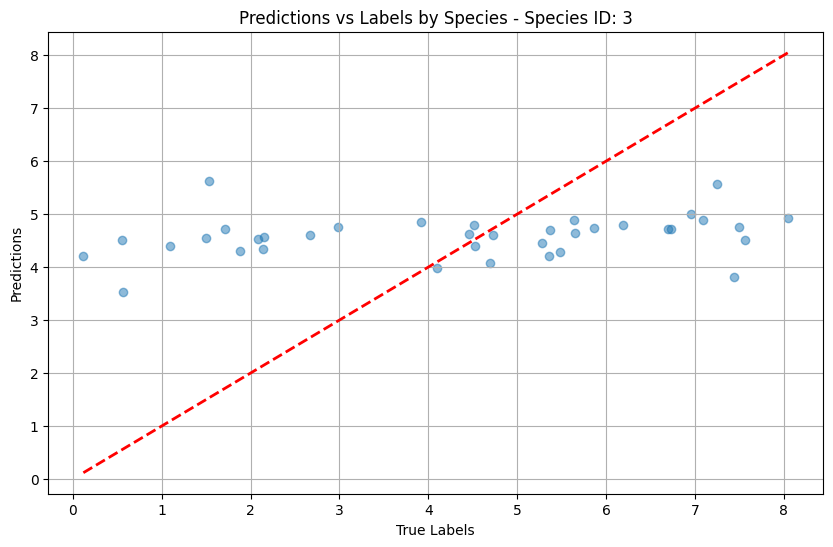

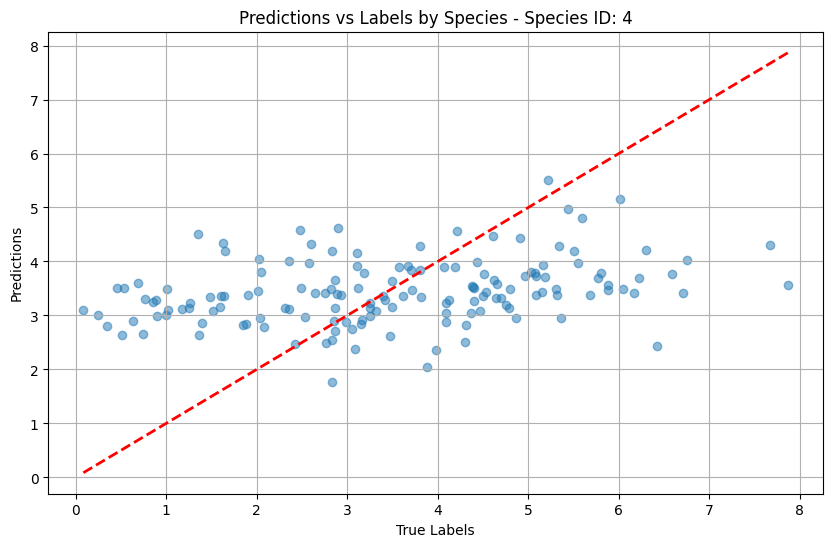

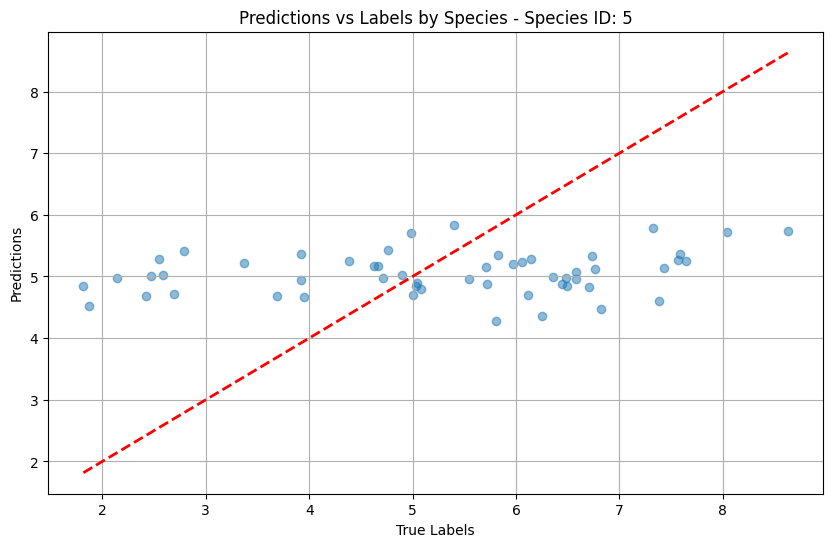

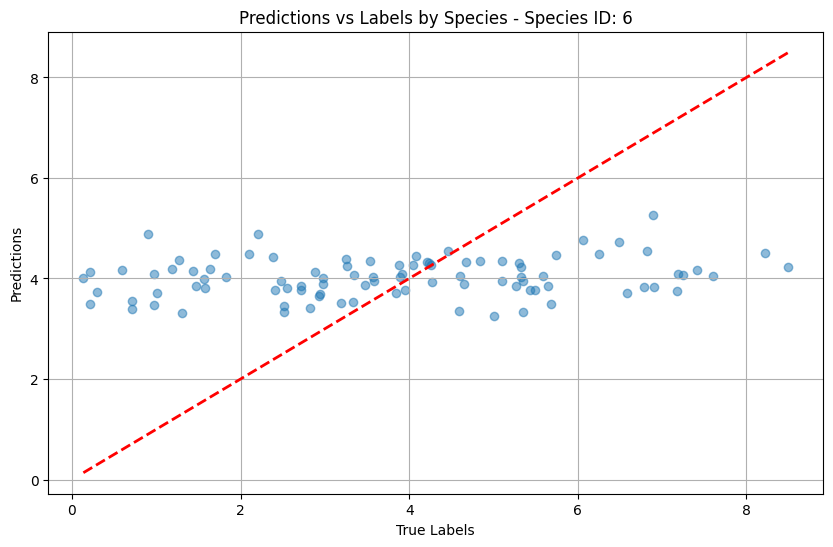

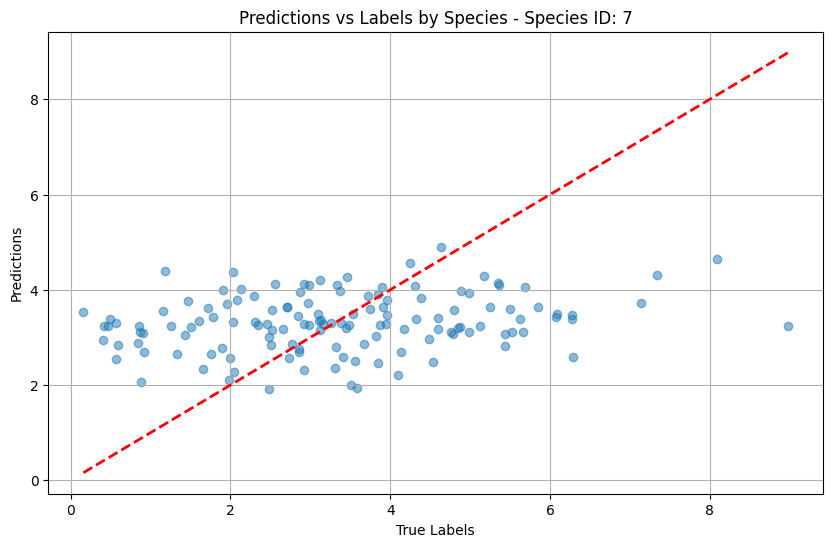

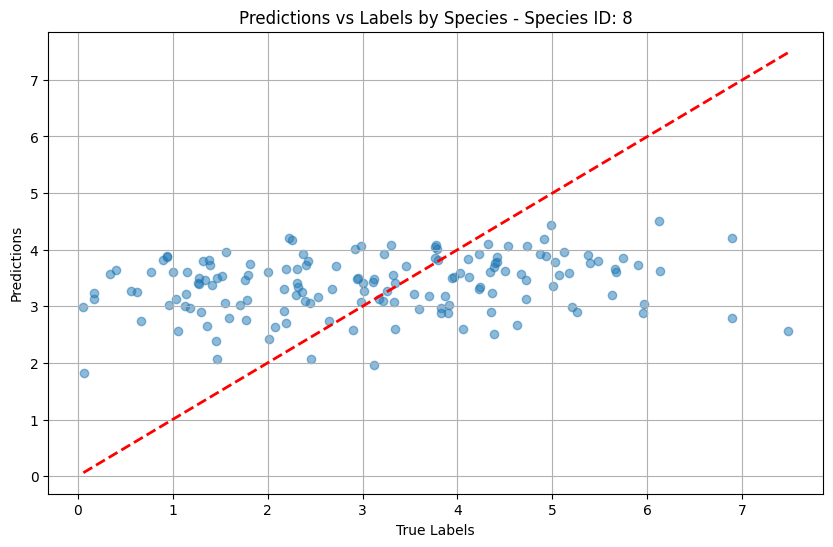

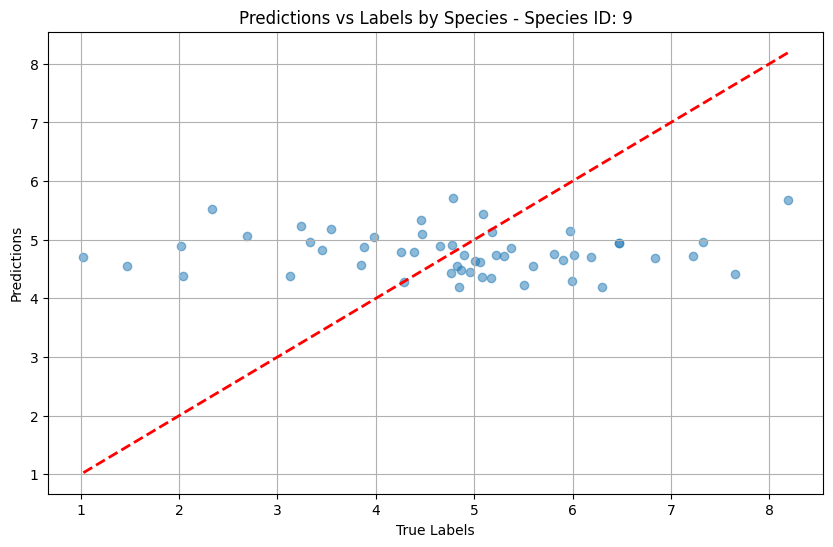

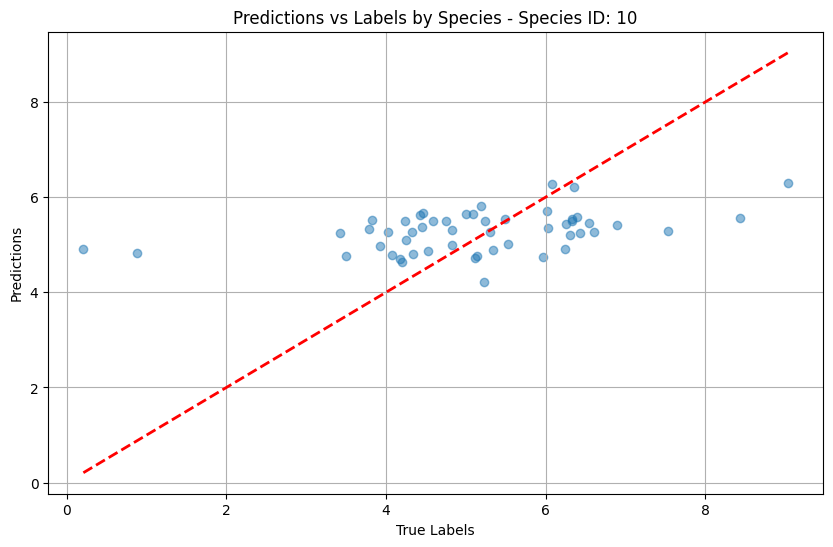

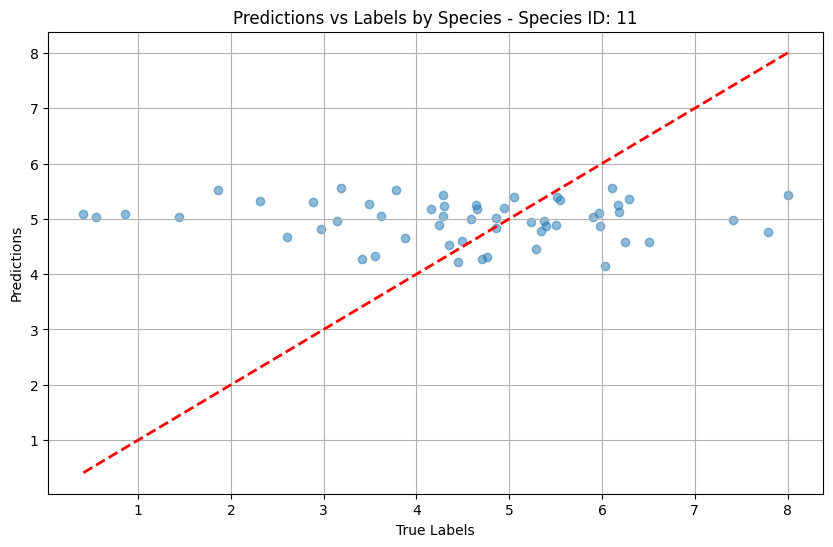

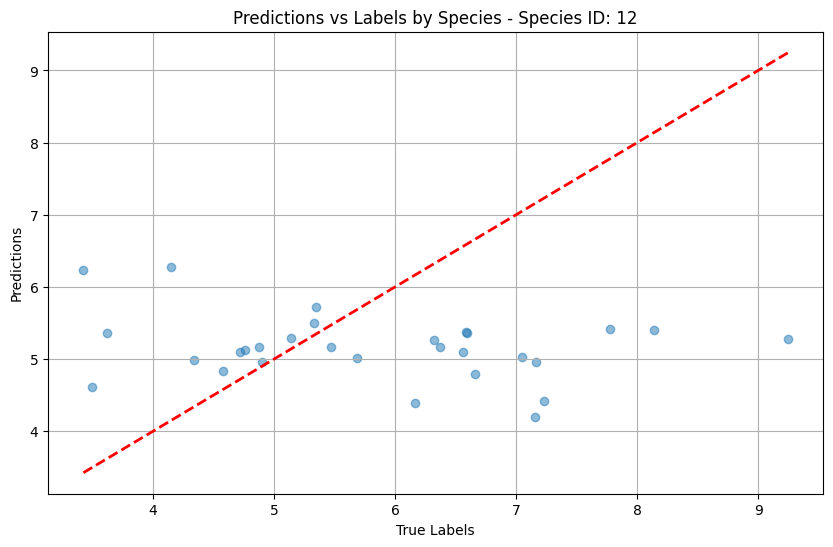

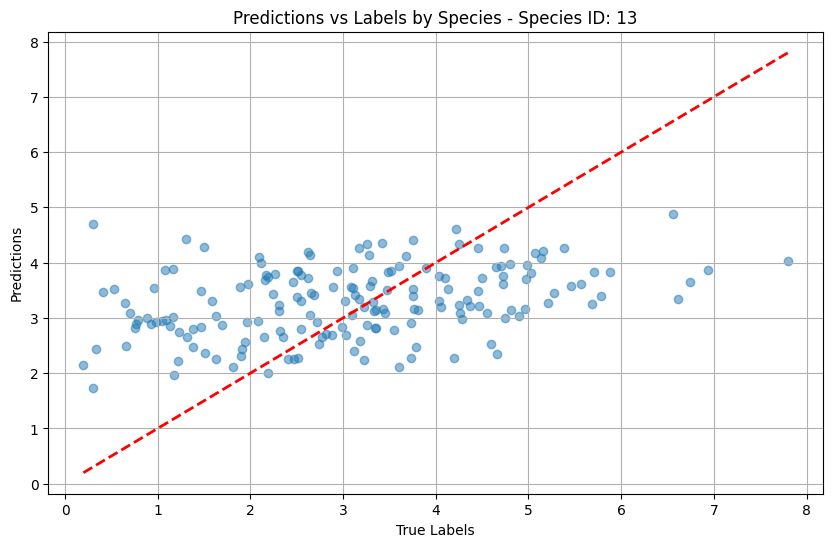

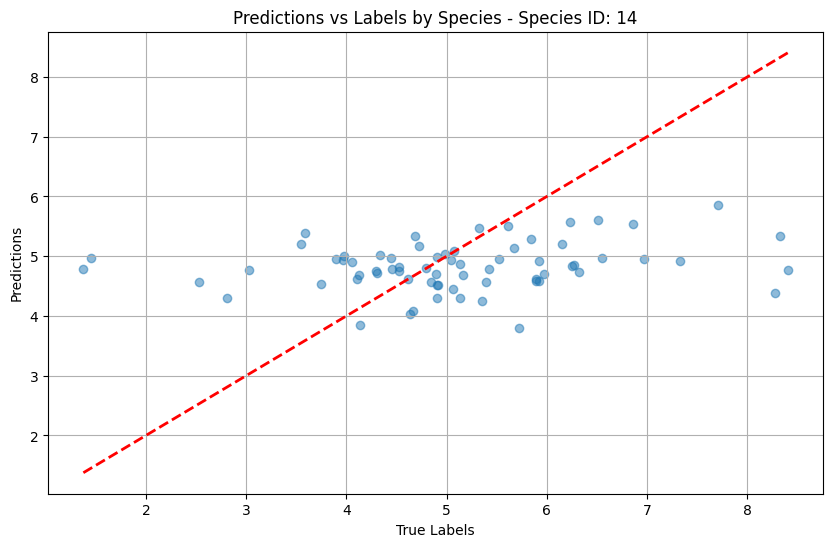

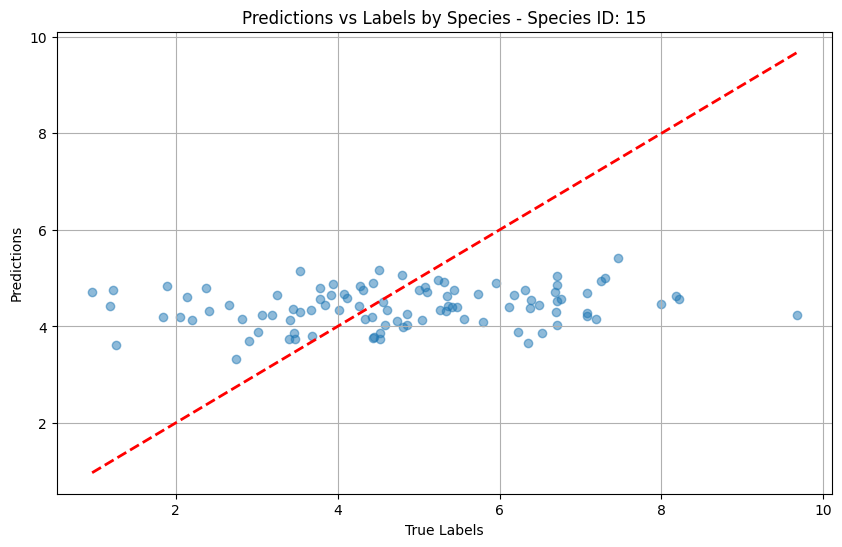

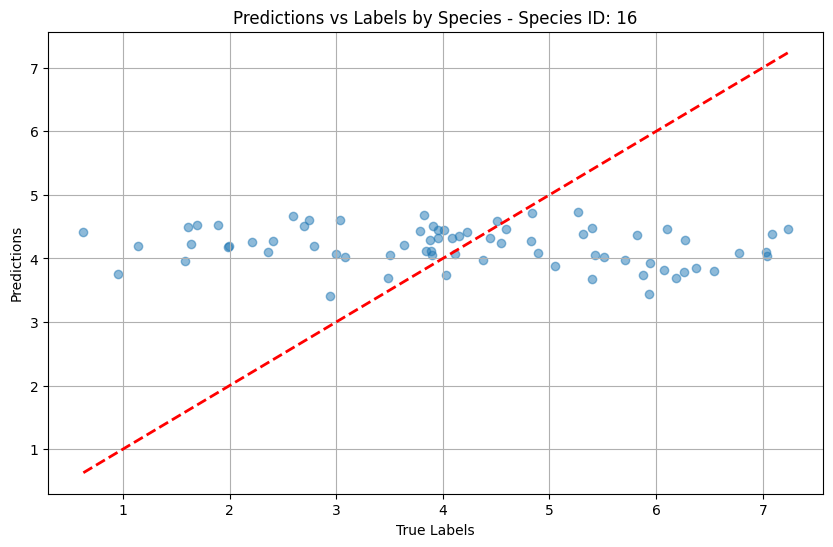

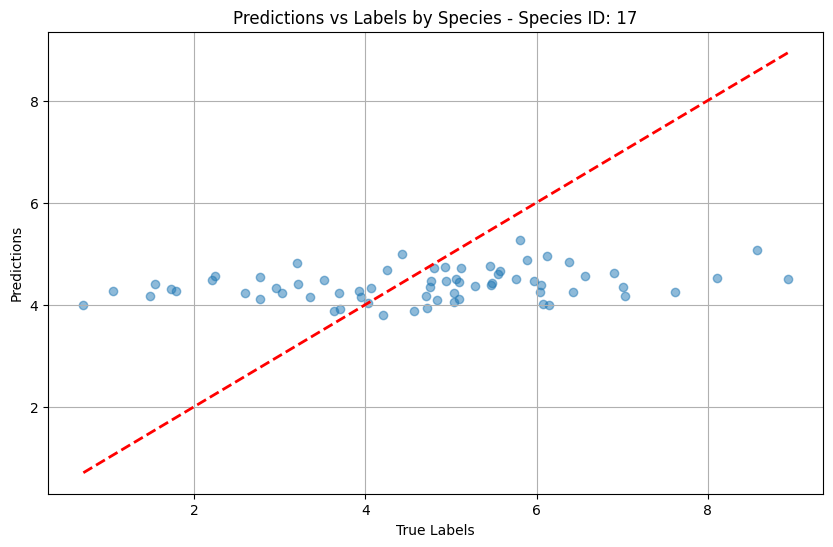

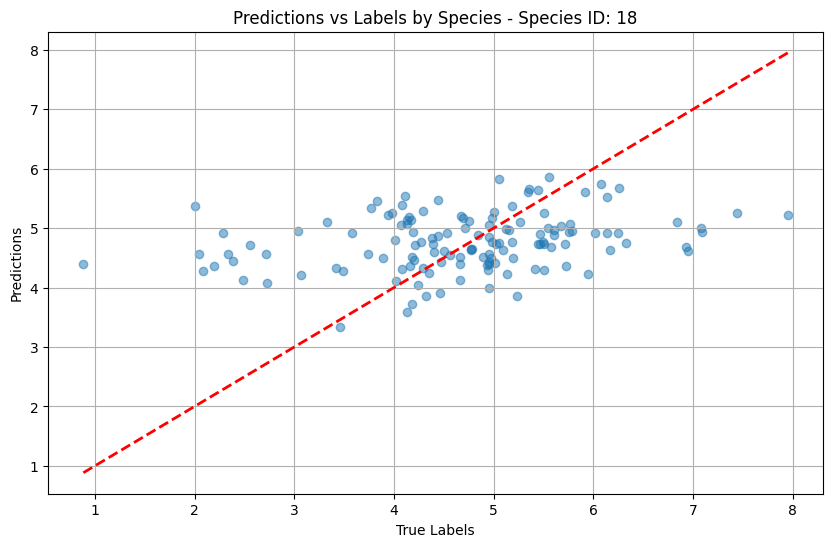

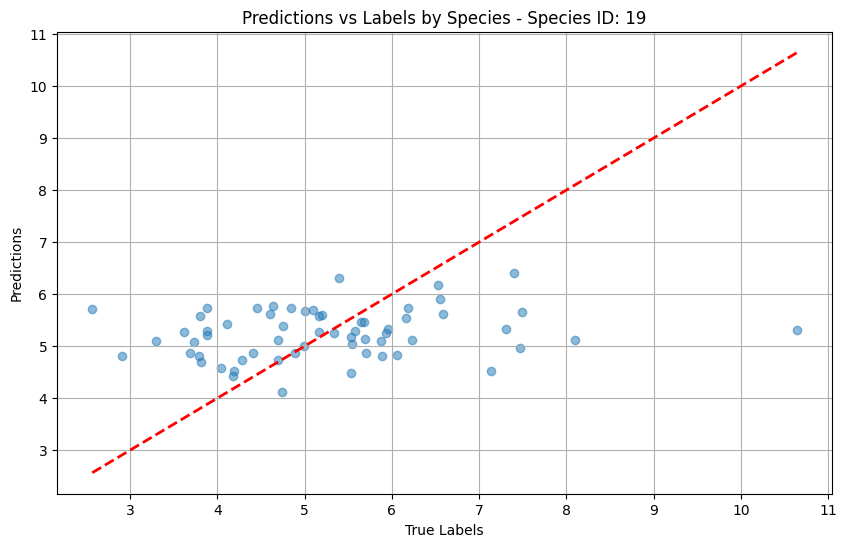

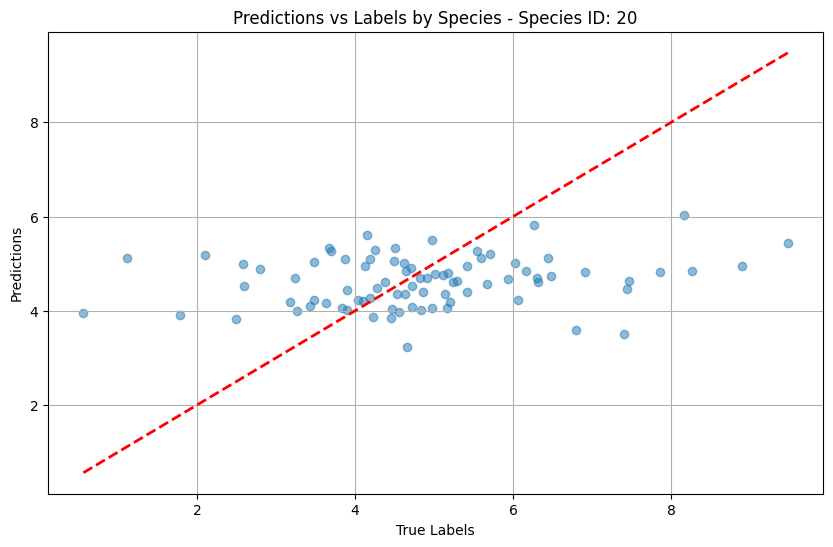

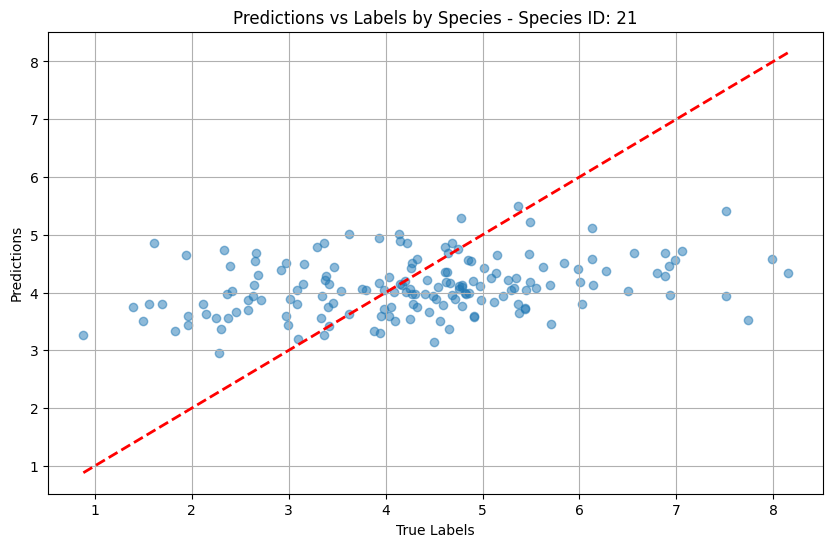

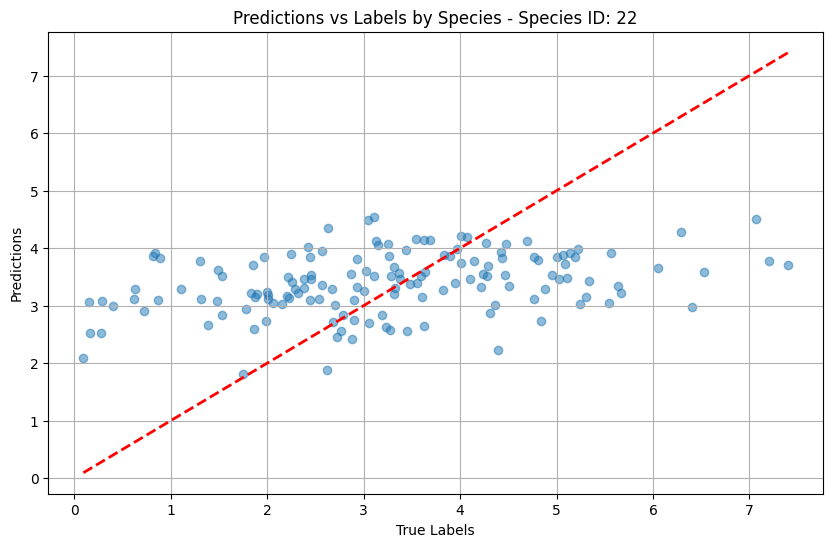

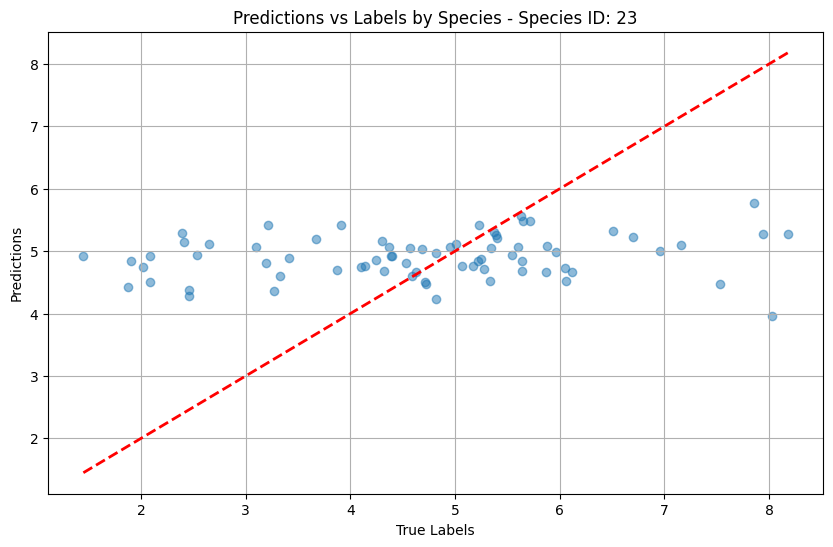

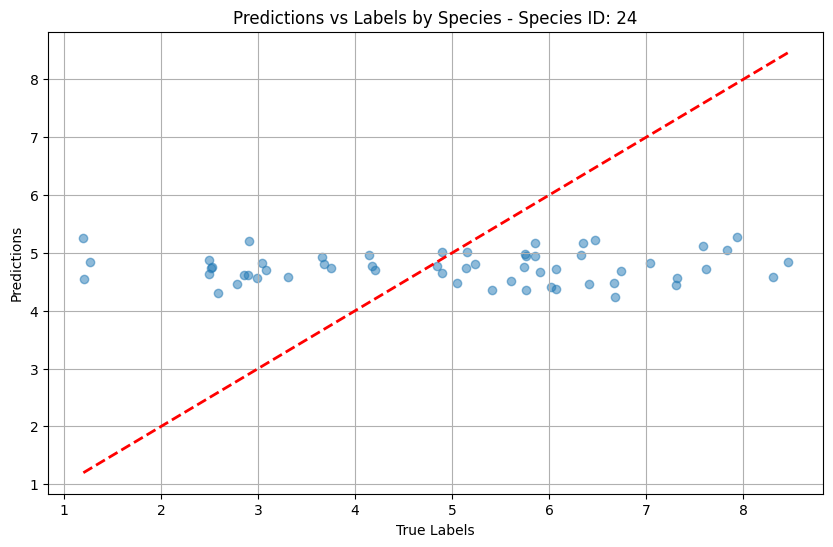

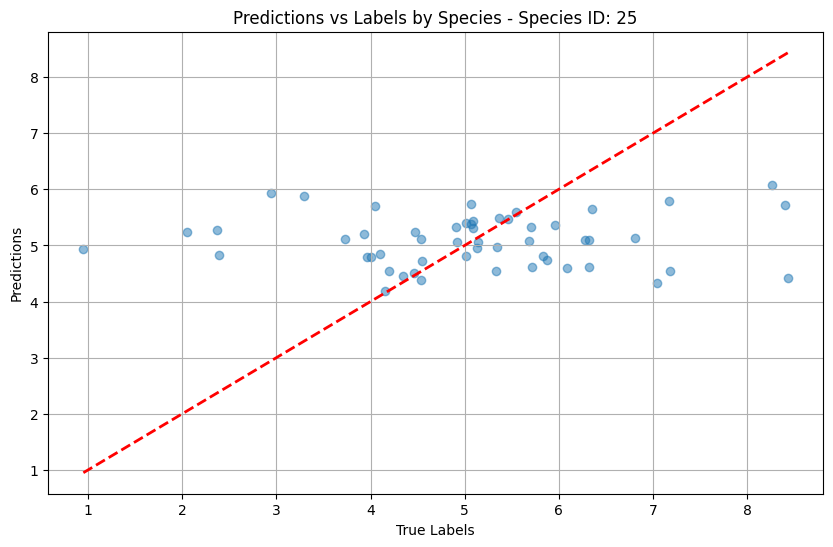

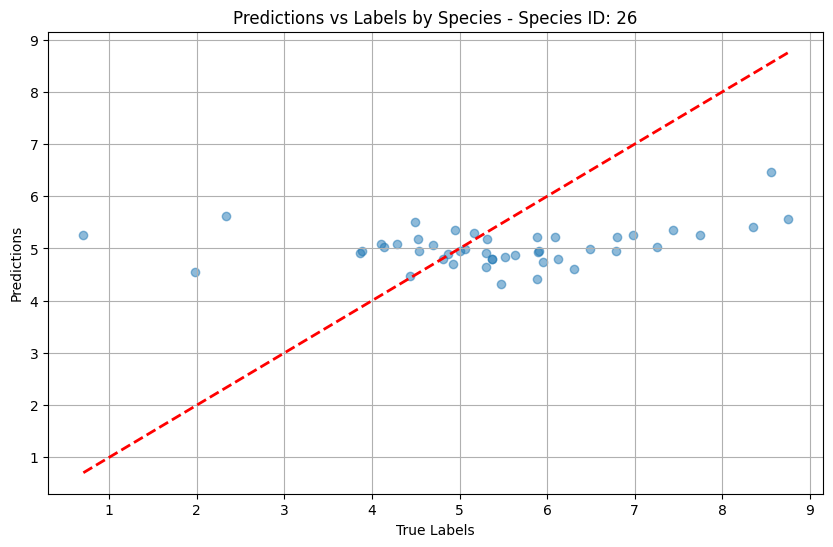

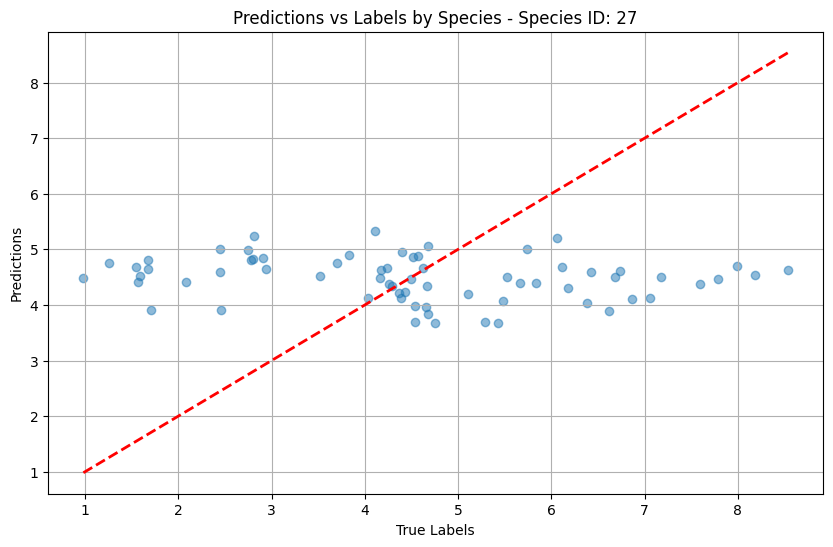

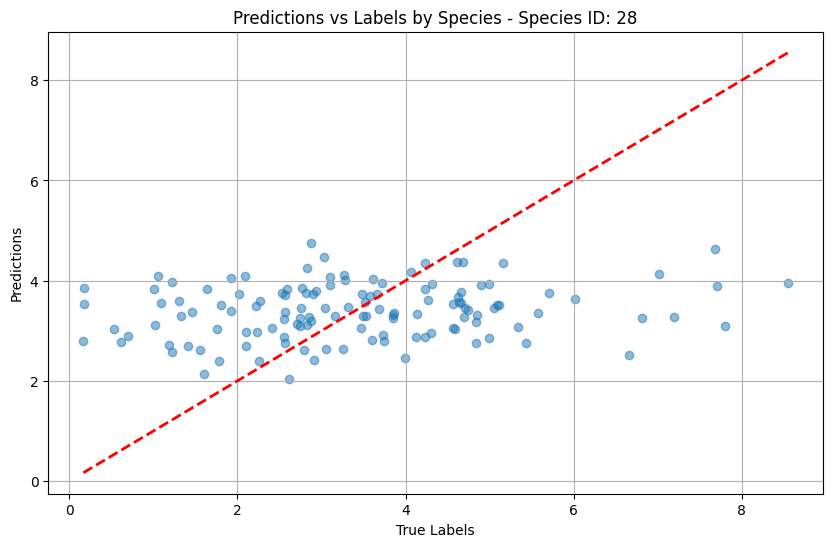

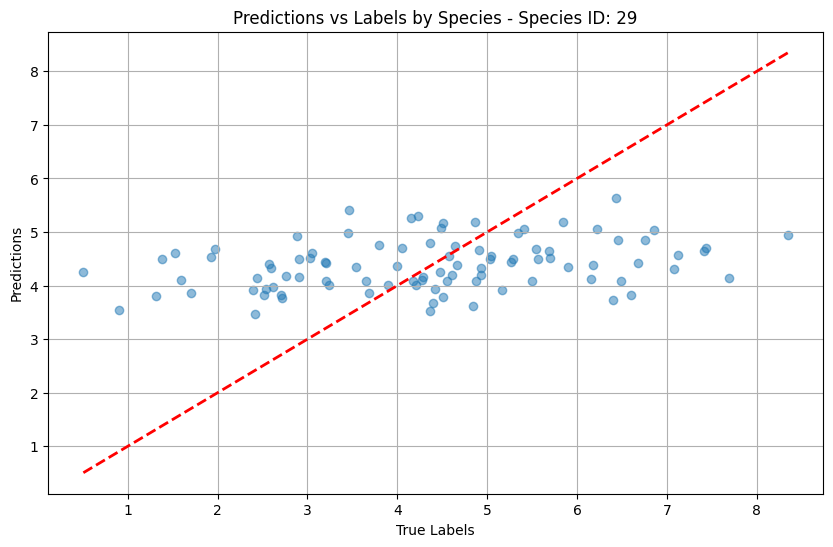

In [116]:
plot_predictions_vs_labels_by_species(predictions, labels, species_ids)


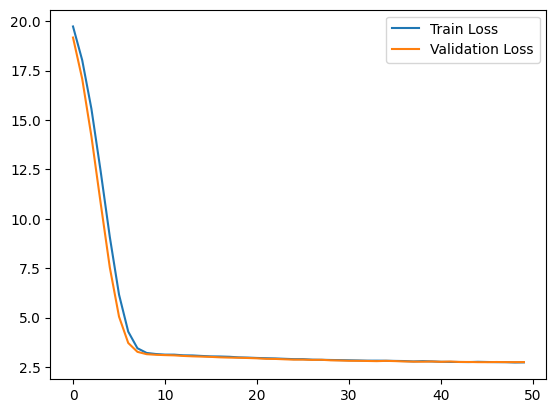

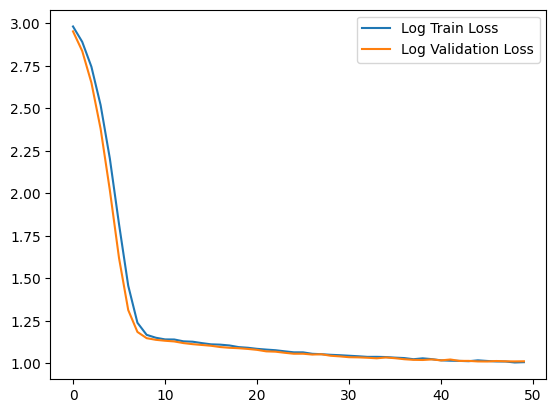

In [20]:
plot_losses(train_losses, val_losses)